In [2]:
# importing libraries
import numpy as np
import pandas as pd

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# importing optuna
import optuna

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# for feature importance
import shap

In [3]:
# setting palette
sns.set_palette('Blues_d')

In [4]:
# reading data
df = pd.read_csv('/content/Decision Tree - Bank Customer Churn.csv', low_memory = False)

In [5]:
# viewing first few rows of the data
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [6]:
# dropping RowNumber, CustomerId, and Surname columns as they won't serve any purpose in model building
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [7]:
# renaming columns
df.columns = ['credit_score', 'location', 'gender', 'age', 'tenure', 'balance', 'number_of_products', 'has_credit_card', 'is_active_member',
             'estimated_salary', 'exited', 'complain', 'satisfaction_score', 'card_type', 'points_earned']

In [8]:
# vising first few rows of data after dropping and renaming columns
df.head()

,credit_score,location,gender,age,tenure,balance,number_of_products,has_credit_card,is_active_member,estimated_salary,exited,complain,satisfaction_score,card_type,points_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [9]:
# data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   credit_score        10000 non-null  int64  
 1   location            10000 non-null  object 
 2   gender              10000 non-null  object 
 3   age                 10000 non-null  int64  
 4   tenure              10000 non-null  int64  
 5   balance             10000 non-null  float64
 6   number_of_products  10000 non-null  int64  
 7   has_credit_card     10000 non-null  int64  
 8   is_active_member    10000 non-null  int64  
 9   estimated_salary    10000 non-null  float64
 10  exited              10000 non-null  int64  
 11  complain            10000 non-null  int64  
 12  satisfaction_score  10000 non-null  int64  
 13  card_type           10000 non-null  object 
 14  points_earned       10000 non-null  int64  
dtypes: float64(2), int64(10), object(3)
memory usage: 1.1+

In [10]:
# checking for duplicate records, if any
print(f'Banking data contains {sum(df.duplicated())} duplicate records.')

Banking data contains 0 duplicate records.


In [11]:
# checking for missing records, if any
print(f'Banking data contains {sum(df.isnull().sum())} missing records.')

Banking data contains 0 missing records.


In [12]:
# inspecting object type columns for any discrepancies
object_columns = list(df.select_dtypes(include = 'object').columns)

for column in object_columns:
    print(f'{column}:\n{df[column].unique()}', end = '\n\n')

location:
['France' 'Spain' 'Germany']

gender:
['Female' 'Male']

card_type:
['DIAMOND' 'GOLD' 'SILVER' 'PLATINUM']



In [13]:
# converting card_type column to sentence case
df['card_type'] = df['card_type'].str.capitalize()

In [14]:
df['exited'].value_counts().rename({0:'Retained', 1:'Churned'}).index

Index(['Retained', 'Churned'], dtype='object', name='exited')

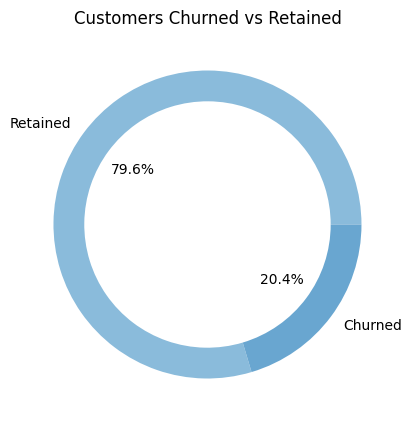

In [15]:
# inspecting number of churned customer vs retained customers
plt.figure(figsize = (5, 5))
plt.pie(x = df['exited'].value_counts().values, labels = df['exited'].value_counts().rename({0:'Retained', 1:'Churned'}).index,
        autopct = '%1.1f%%', wedgeprops = {'width':0.20})
plt.title('Customers Churned vs Retained')
plt.show()

**Insights:** The pie chart indicates that the majority of customers are retained, which is a positive sign for the company's customer loyalty and retention strategies. However, the churn rate of 20.4% should still be addressed to further improve customer satisfaction and retention.

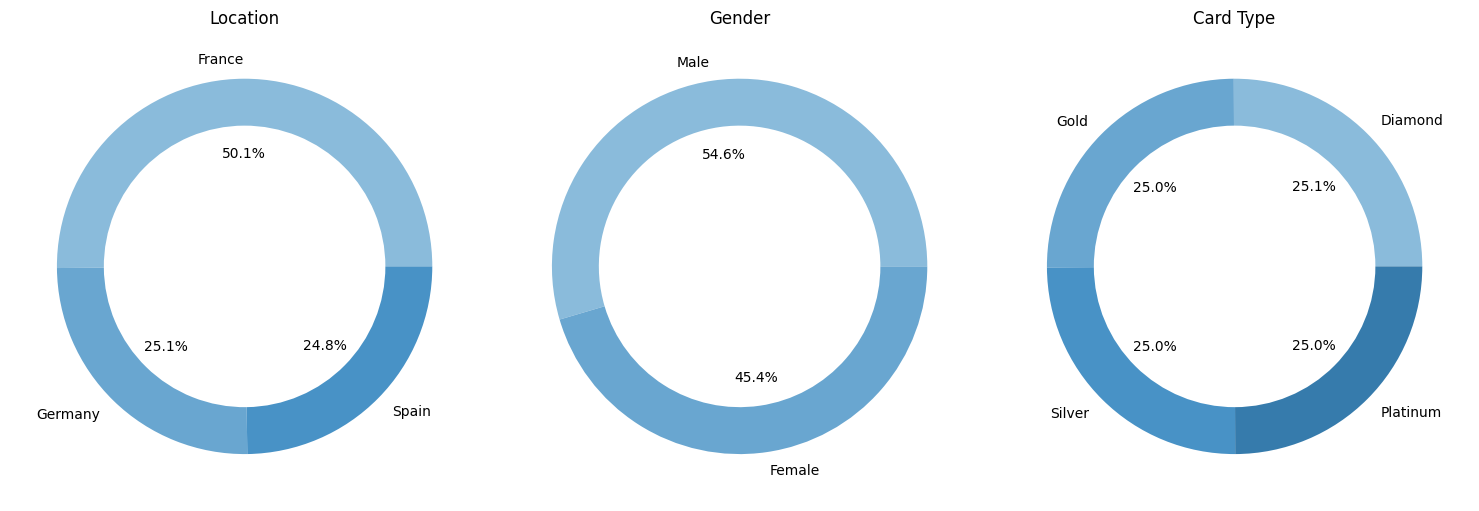

In [16]:
# visualizing object type columns to see data distribution
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

axs[0].pie(df['location'].value_counts().values, labels = df['location'].value_counts().index, autopct = '%1.1f%%', wedgeprops = {'width':0.25})
axs[0].set_title('Location')

axs[1].pie(df['gender'].value_counts().values, labels = df['gender'].value_counts().index, autopct = '%1.1f%%', wedgeprops = {'width':0.25})
axs[1].set_title('Gender')

axs[2].pie(df['card_type'].value_counts().values, labels = df['card_type'].value_counts().index, autopct = '%1.1f%%', wedgeprops = {'width':0.25})
axs[2].set_title('Card Type')

plt.tight_layout()
plt.show()

**Insights:**
- Majority of the data points are from France, accounting for 50.1% of the total. Germany and Spain have almost equal representation, with Germany slightly higher at 25.1% compared to Spain's 24.8%.
- There is a higher percentage of Males (54.6%) compared to Females (45.4%).
- The distribution of card types is almost equal.

In [17]:
# statistical summary
round(df.describe().loc[['mean', 'min', '25%', '50%', '75%', 'max', 'std']], 2).T

,mean,min,25%,50%,75%,max,std
credit_score,650.53,350.00,584.00,652.00,718.00,850.00,96.65
age,38.92,18.00,32.00,37.00,44.00,92.00,10.49
tenure,5.01,0.00,3.00,5.00,7.00,10.00,2.89
balance,76485.89,0.00,0.00,97198.54,127644.24,250898.09,62397.41
number_of_products,1.53,1.00,1.00,1.00,2.00,4.00,0.58
has_credit_card,0.71,0.00,0.00,1.00,1.00,1.00,0.46
is_active_member,0.52,0.00,0.00,1.00,1.00,1.00,0.50
estimated_salary,100090.24,11.58,51002.11,100193.92,149388.25,199992.48,57510.49
exited,0.20,0.00,0.00,0.00,0.00,1.00,0.40
complain,0.20,0.00,0.00,0.00,0.00,1.00,0.40


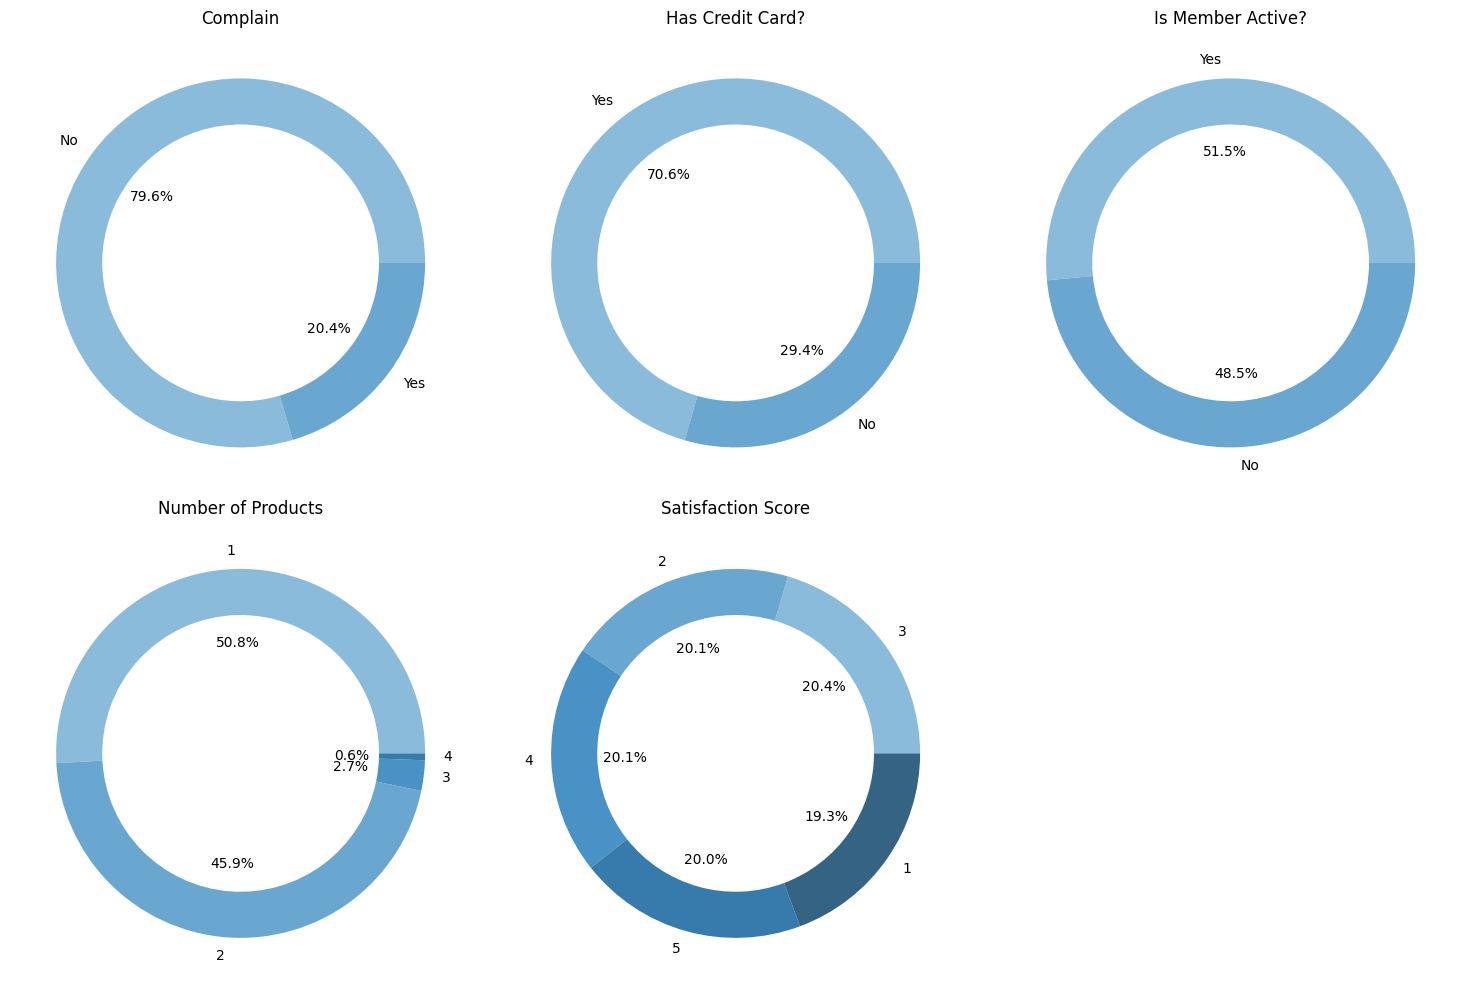

In [18]:
# visualizing categorical columns
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))

axs[0][0].pie(x = df['complain'].value_counts().values, labels = df['complain'].value_counts().rename({0:'No', 1:'Yes'}).index,
             autopct = '%1.1f%%', wedgeprops = {'width':0.25})
axs[0][0].set_title('Complain')

axs[0][1].pie(x = df['has_credit_card'].value_counts().values, labels = df['has_credit_card'].value_counts().rename({0:'No', 1:'Yes'}).index,
              autopct = '%1.1f%%', wedgeprops = {'width':0.25})
axs[0][1].set_title('Has Credit Card?')

axs[0][2].pie(x = df['is_active_member'].value_counts().values, labels = df['is_active_member'].value_counts().rename({0:'No', 1:'Yes'}).index,
             autopct = '%1.1f%%', wedgeprops = {'width':0.25})
axs[0][2].set_title('Is Member Active?')

axs[1][0].pie(x = df['number_of_products'].value_counts().values, labels = df['number_of_products'].value_counts().index, autopct = '%1.1f%%',
              wedgeprops = {'width':0.25})
axs[1][0].set_title('Number of Products')

axs[1][1].pie(x = df['satisfaction_score'].value_counts().values, labels = df['satisfaction_score'].value_counts().index, autopct = '%1.1f%%',
              wedgeprops = {'width':0.25})
axs[1][1].set_title('Satisfaction Score')

axs[1][2].set_visible(False)

plt.tight_layout()
plt.show()

**Insights:**
- Majority of customers did not lodge complaints.
- Most customers possess a credit card.
- Customers are almost evenly split between active and inactive members, with a slight majority being active.
- Most customers had either 1 or 2 products, with very few having 3 or more products.
- Satisfaction scores are fairly evenly distributed across all levels, with no significant skew towards any particular score.

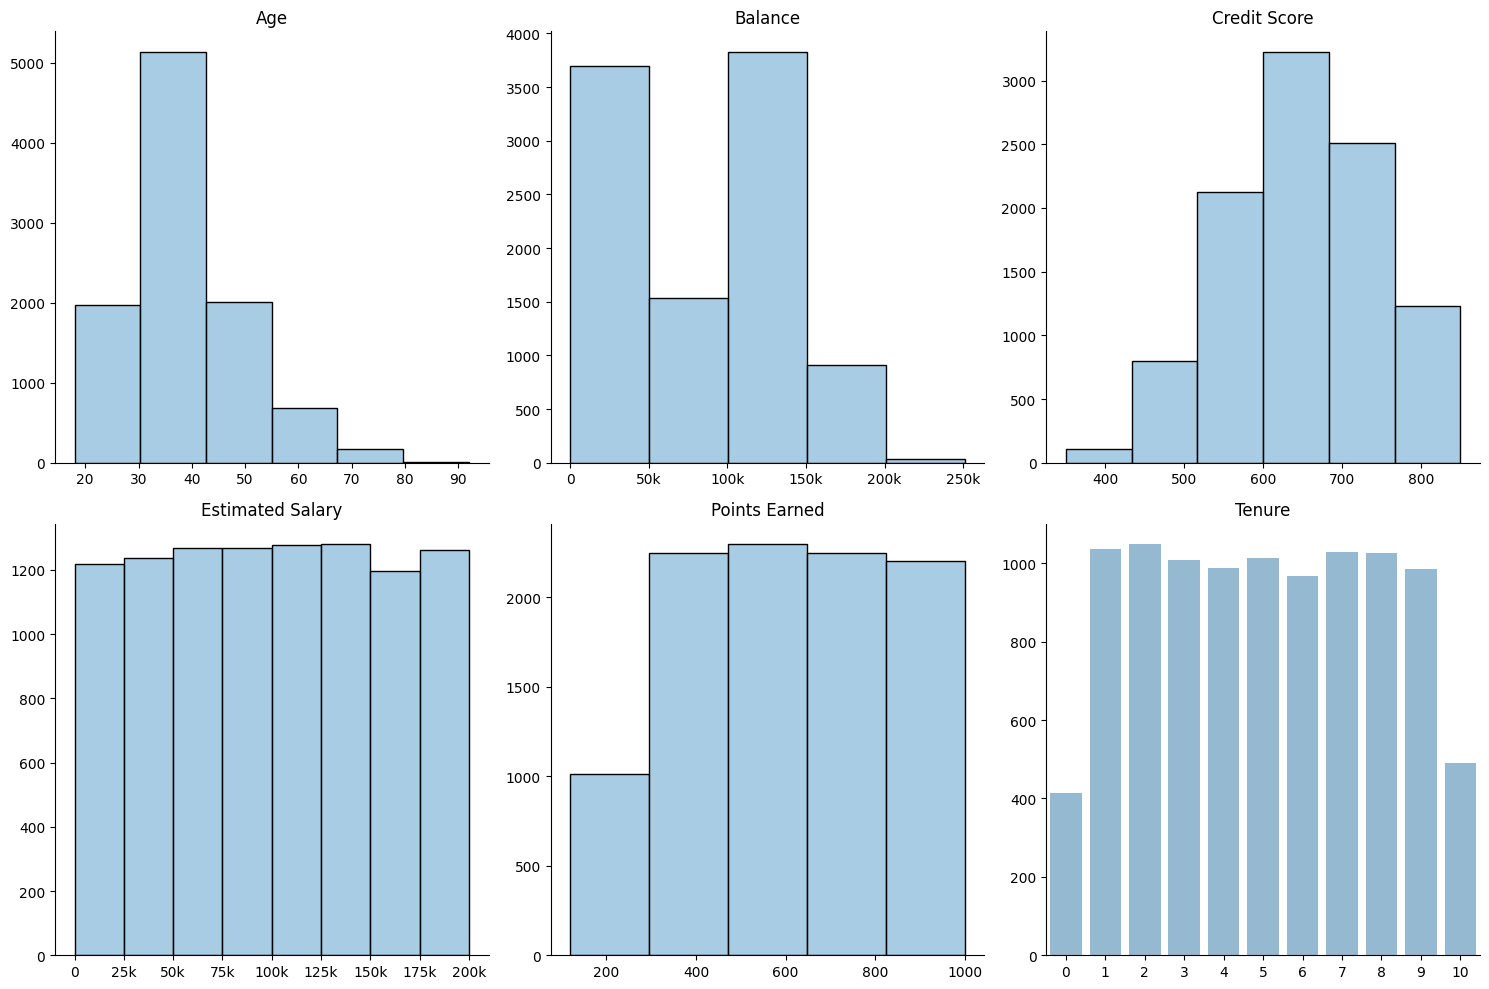

In [19]:
# visualizing numerical type columns to see data distribution
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))

sns.histplot(data = df, x = 'age', bins = 6, ax = axs[0][0])
axs[0][0].set_title('Age')
axs[0][0].set_xlabel('')
axs[0][0].set_ylabel('')
axs[0][0].spines[['top', 'right']].set_visible(False)

sns.histplot(data = df, x = 'balance', bins = 5, ax = axs[0][1])
axs[0][1].set_title('Balance')
axs[0][1].set_xlabel('')
axs[0][1].set_xticks([0, 50000, 100000, 150000, 200000, 250000], [0, '50k', '100k', '150k', '200k', '250k'])
axs[0][1].set_ylabel('')
axs[0][1].spines[['top', 'right']].set_visible(False)

sns.histplot(data = df, x = 'credit_score', bins = 6, ax = axs[0][2])
axs[0][2].set_title('Credit Score')
axs[0][2].set_xlabel('')
axs[0][2].set_ylabel('')
axs[0][2].spines[['top', 'right']].set_visible(False)

sns.histplot(data = df, x = 'estimated_salary', bins = 8, ax = axs[1][0])
axs[1][0].set_title('Estimated Salary')
axs[1][0].set_xlabel('')
axs[1][0].set_xticks([0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000], [0, '25k', '50k', '75k', '100k', '125k', '150k', '175k', '200k'])
axs[1][0].set_ylabel('')
axs[1][0].spines[['top', 'right']].set_visible(False)

sns.histplot(data = df, x = 'points_earned', bins = 5, ax = axs[1][1])
axs[1][1].set_title('Points Earned')
axs[1][1].set_xlabel('')
axs[1][1].set_ylabel('')
axs[1][1].spines[['top', 'right']].set_visible(False)

sns.countplot(data = df, x = 'tenure', ax = axs[1][2])
axs[1][2].set_title('Tenure')
axs[1][2].set_xlabel('')
axs[1][2].set_ylabel('')
axs[1][2].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

**Insights:**
- **Age:** The histogram shows that the majority of customers fall between 30 and 40 years old, with fewer individuals in the age ranges of 20-30, 40-50, and very few above 50.
- **Balance:** Most customers have account balances between 0 and 150k, with the highest frequency in the 0k-50k and 100k-150k range. There are fewer individuals with balances above 150k.
- **Credit Score:** Majority of individuals have credit scores between 600 and 700. There are fewer individuals with scores below 500 and above 800.
- **Estimated Salary:** The distribution of estimated salaries appears to be relatively uniform across different salary ranges from 0 to 200k.
- **Points Earned:** Most individuals have earned between 250 and 1000 points, with fewer individuals having points below 250.
- **Tenure:** The tenure distribution is relatively even across different values from 1 to 9 years.

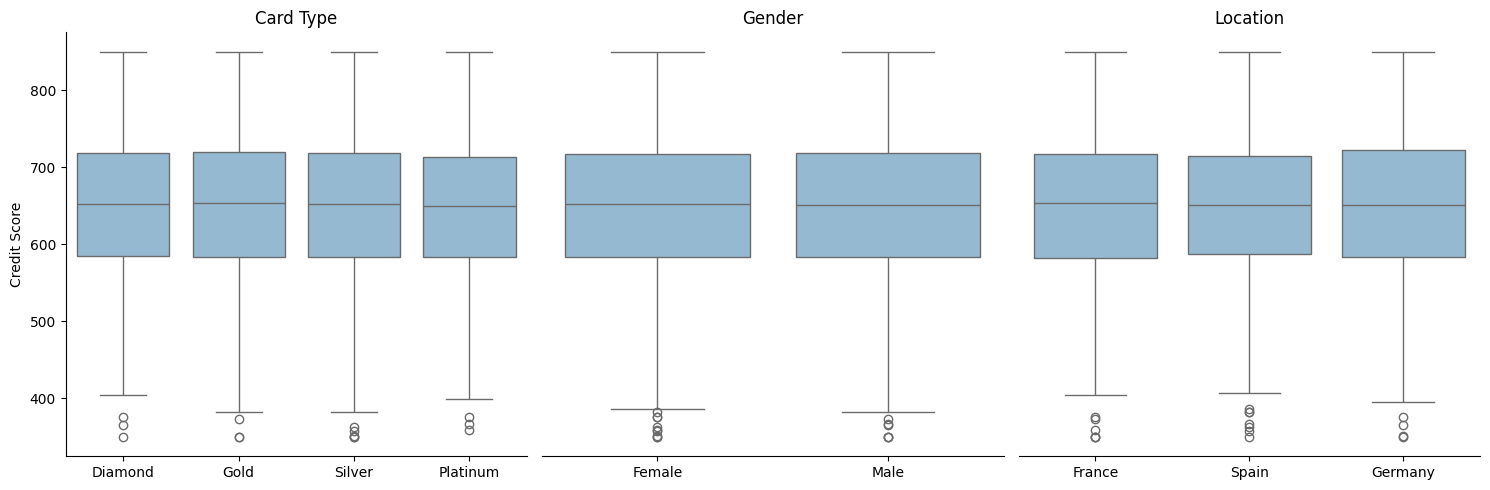

In [20]:
# credit score by card type, gender, and location
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

sns.boxplot(data = df, x = 'card_type', y = 'credit_score', ax = axs[0])
axs[0].set_title('Card Type')
axs[0].set_xlabel('')
axs[0].set_ylabel('Credit Score')
axs[0].spines[['top', 'right']].set_visible(False)

sns.boxplot(data = df, x = 'gender', y = 'credit_score', ax = axs[1])
axs[1].set_title('Gender')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].spines[['left', 'top', 'right']].set_visible(False)

sns.boxplot(data = df, x = 'location', y = 'credit_score', ax = axs[2])
axs[2].set_title('Location')
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].set_yticks([])
axs[2].spines[['left', 'top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

**Insights:**
- **Card Type**
  - The median credit scores for Diamond, Gold, Silver, and Platinum card types are all around 650.
  - The interquartile ranges (IQR) for all card types are similar, indicating a similar spread of credit scores.
  - There are some outliers below the lower whisker, indicating a few individuals with significantly lower credit scores.
- **Gender**
  - The median credit scores for both Female and Male categories are also around 650.
  - The IQRs for both genders are similar, suggesting a similar distribution of credit scores.
  - There are a few outliers below the lower whisker for both Female and Male categories.
- **Location**
  - The median credit scores for France, Spain, and Germany are all around 650.
  - The IQRs for all three locations are similar, indicating a similar spread of credit scores.
  - There are some outliers below the lower whisker for all three locations.

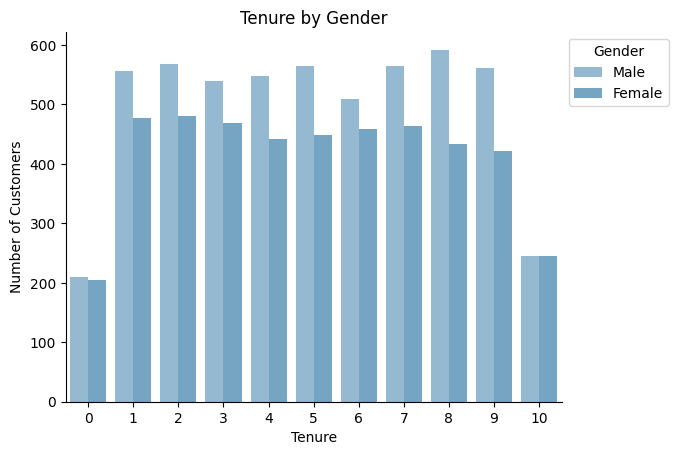

In [21]:
# visualizing tenure by gender
sns.countplot(data = df, x = 'tenure', hue = 'gender')
plt.title('Tenure by Gender')
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')

plt.legend(title = 'Gender', bbox_to_anchor = (1, 1), loc = 'upper left')
plt.gca().spines[['top', 'right']].set_visible(False)

plt.show()

**Insights:**
- The number of male customers is slightly higher than the female customers for most tenure values.
- Both genders have the lowest number of customers at tenure values of 0 and 10.

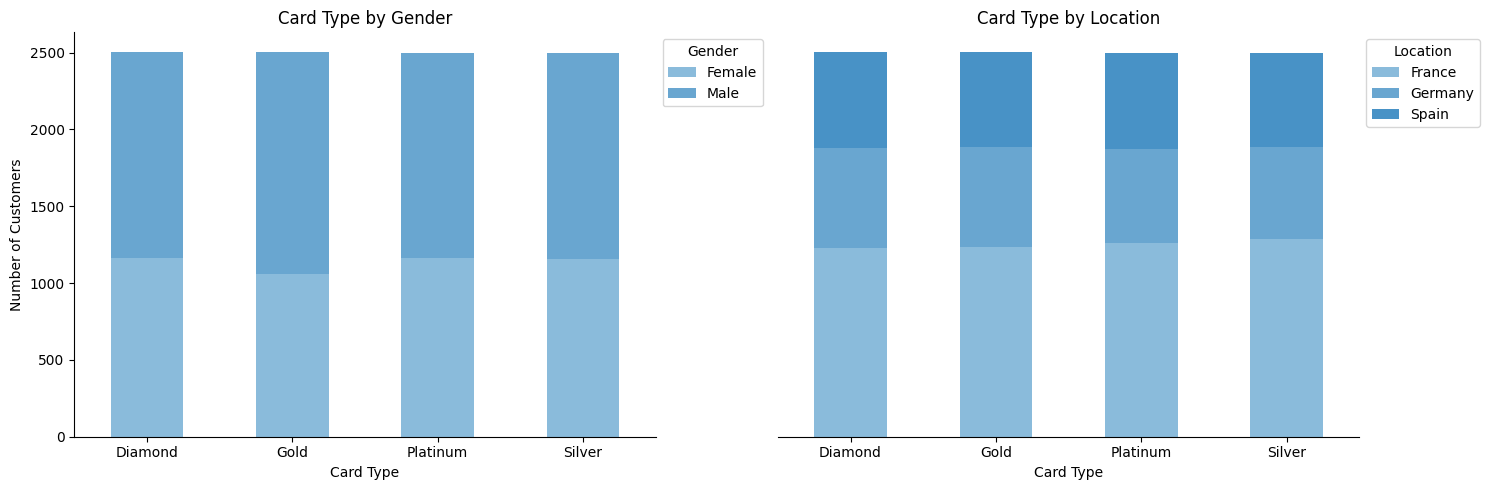

In [22]:
# card type by gender and location
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

data = df.groupby('card_type')['gender'].value_counts().unstack()
data.plot(kind = 'bar', stacked = True, ax = axs[0], rot = 0)
axs[0].set_title('Card Type by Gender')
axs[0].set_xlabel('Card Type')
axs[0].set_ylabel('Number of Customers')
axs[0].legend(title = 'Gender', bbox_to_anchor = (1, 1), loc = 'upper left')
axs[0].spines[['top', 'right']].set_visible(False)

data = df.groupby('card_type')['location'].value_counts().unstack()
data.plot(kind = 'bar', stacked = True, ax = axs[1], rot = 0)
axs[1].set_title('Card Type by Location')
axs[1].set_xlabel('Card Type')
axs[1].set_ylabel('')
axs[1].set_yticks([])
axs[1].legend(title = 'Location', bbox_to_anchor = (1, 1), loc = 'upper left')
axs[1].spines[['left', 'top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

**Insights:**
- The number of customers for each card type is approximately 2500, with a roughly equal split between Female and Male customers.
- The number of customers for each card type is approximately 2500, with nearly 50% customers from France and roughly 25% customers from Germany & Spain.

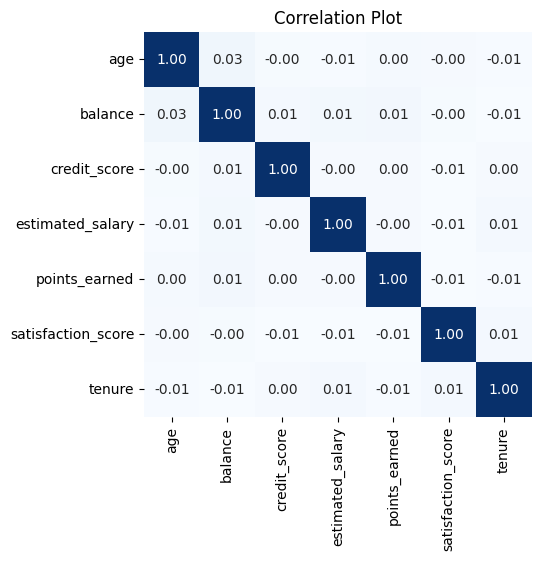

In [33]:
# correlation plot
plt.figure(figsize = (5, 5))
sns.heatmap(df[['age', 'balance', 'credit_score', 'estimated_salary', 'points_earned', 'satisfaction_score', 'tenure']].corr(), annot = True, fmt = '.2f',
            cmap = 'Blues', cbar = False)
plt.title('Correlation Plot')
plt.show()

In [24]:
# performing one hot encoding
df = pd.get_dummies(data = df, drop_first = True)

boolean_columns = list(df.select_dtypes(include = 'bool').columns)

for column in boolean_columns:
    df[column] = df[column].astype(int)

df.head()

,credit_score,age,tenure,balance,number_of_products,has_credit_card,is_active_member,estimated_salary,exited,complain,satisfaction_score,points_earned,location_Germany,location_Spain,gender_Male,card_type_Gold,card_type_Platinum,card_type_Silver
0,619,42,2,0.00,1,1,1,101348.88,1,1,2,464,0,0,0,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,3,456,0,1,0,0,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,3,377,0,0,0,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,5,350,0,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,5,425,0,1,0,1,0,0


In [25]:
# spillting data into features and target variable
x = df.drop('exited', axis = 1)
y = df['exited']

In [26]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

In [27]:
# finding best parameters for decision tree classifier using optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 21)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 51)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 51)

    model = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf, random_state = 1)

    model.fit(x_train, y_train)

    y_test_pred = model.predict(x_test)
    recall = recall_score(y_test, y_test_pred)

    return round(recall * 100, 2)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print('Best Trial:')
print(f'Higest Recall: {study.best_trial.value}')
print(f'Best Parameters: {study.best_trial.params}')

Best Trial:
Higest Recall: 99.68
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 47, 'min_samples_leaf': 9}


In [28]:
# rebuilding model with best parameters
best_params = study.best_trial.params

model = DecisionTreeClassifier(**best_params, random_state = 1)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)

print('Model Precision: ', round(precision * 100, 2), '%', sep = '')
print('Model Recall: ', round(recall * 100, 2), '%', sep = '')
print('Model Accuracy: ', round(accuracy * 100, 2), '%', sep = '')

Model Precision: 99.52%
Model Recall: 99.68%
Model Accuracy: 99.83%


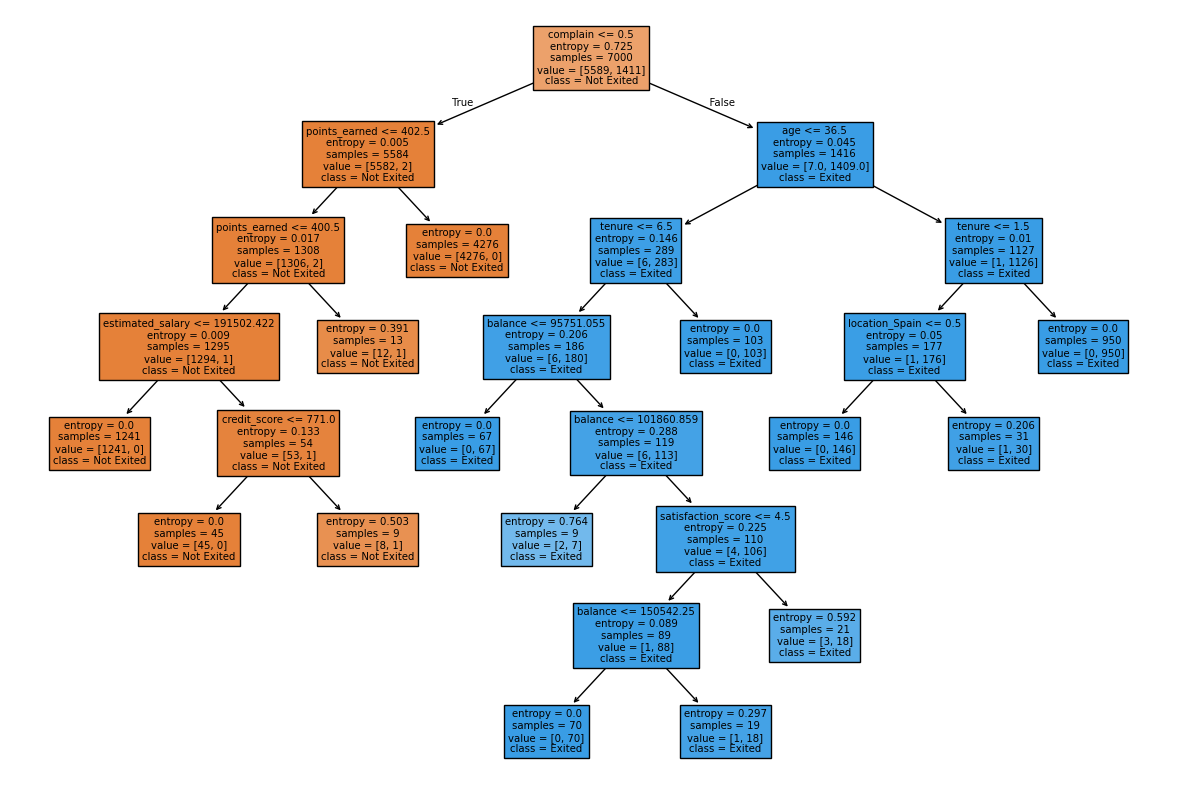

In [29]:
# visualizing decision tree
plt.figure(figsize = (15, 10))
plot_tree(model, filled = True, feature_names = x.columns, class_names = ['Not Exited', 'Exited'])
plt.show()

In [30]:
# finding best parameters for random forest classifier using optuna
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    n_estimators = trial.suggest_int('n_estimators', 2, 500)
    max_depth = trial.suggest_int('max_depth', 2, 51)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 51)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 51)

    model = RandomForestClassifier(criterion = criterion, max_features = max_features, n_estimators = n_estimators, max_depth = max_depth,
                                  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 1, n_jobs = -1)

    model.fit(x_train, y_train)

    y_test_pred = model.predict(x_test)
    recall = recall_score(y_test, y_test_pred)

    return round(recall * 100, 2)

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

print('Best Trial:')
print(f'Higest Recall: {study.best_trial.value}')
print(f'Best Parameters: {study.best_trial.params}')

Best Trial:
Higest Recall: 99.68
Best Parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 285, 'max_depth': 29, 'min_samples_split': 43, 'min_samples_leaf': 24}


In [31]:
# rebuilding model with best parameters
best_params = study.best_trial.params

model = RandomForestClassifier(**best_params, random_state = 1, n_jobs = -1)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)

print('Model Precision: ', round(precision * 100, 2), '%', sep = '')
print('Model Recall: ', round(recall * 100, 2), '%', sep = '')
print('Model Accuracy: ', round(accuracy * 100, 2), '%', sep = '')

Model Precision: 99.52%
Model Recall: 99.68%
Model Accuracy: 99.83%


 95%|=================== | 5706/6000 [00:21<00:01]       

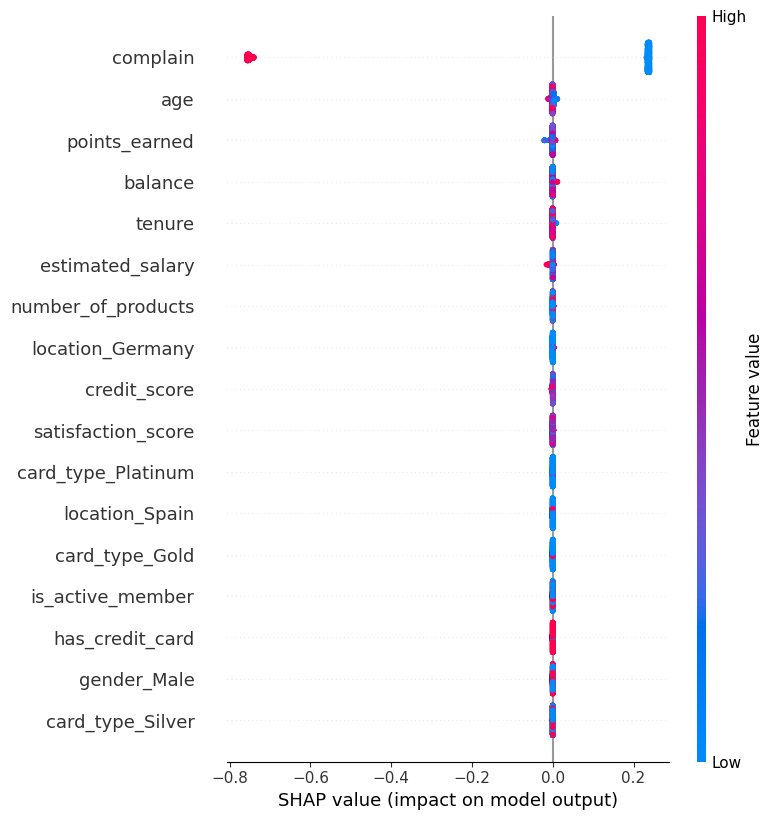

In [32]:
# feature importance
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_test)
shap.summary_plot(shap_values[:,:,0], x_test)

**Insights:** Customer complaints strongly influence retention. When a customer files a complaint, they are significantly less likely to stay with the company. This suggests that addressing customer issues effectively could improve retention rates.